In [84]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast
import functionSQL as f 

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats
from gensim import corpora, models

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

Loading BokehJS ...

In [85]:
conn, cursor = f.init()

data = f.extract_all_data(conn, cursor, 'REVIEWS_CLEANED')
data = pd.DataFrame(data, columns = ['category', 'sub_category', 'name_product', 'star', 'title', 'comment', 'label'])

data.head()

,category,sub_category,name_product,star,title,comment,label
0,Boys' Fashion,Clothing,HonestBaby Unisex Baby Organic Cotton Short Sl...,1,nope buy bad quality,really want like problem order color option tw...,bad
1,Boys' Fashion,Clothing,HonestBaby Unisex Baby Organic Cotton Short Sl...,1,buy,shirt look great picture wash seam start pull ...,bad
2,Boys' Fashion,Clothing,HonestBaby Unisex Baby Organic Cotton Short Sl...,1,worst,bad item ever purchase son look cheap poor qua...,bad
3,Boys' Fashion,Clothing,HonestBaby Unisex Baby Organic Cotton Short Sl...,1,happened,product definitely miss mark begin white shirt...,bad
4,Boys' Fashion,Clothing,HonestBaby Unisex Baby Organic Cotton Short Sl...,1,single stitch seam raw edge buy,single stitch seam video first wash never warn...,bad


In [86]:
comment = data['comment']
comment

0        really want like problem order color option tw...
1        shirt look great picture wash seam start pull ...
2        bad item ever purchase son look cheap poor qua...
3        product definitely miss mark begin white shirt...
4        single stitch seam video first wash never warn...
                               ...                        
45558    package came read two oz jar package seal nice...
45559    use eucerine almost decade give late fatherinl...
45560    bad issue painful dry skin face start use nigh...
45561    deliver quick love stuff skin sensitive dry th...
45562    nothing work like product dry foot even buy ch...
Name: comment, Length: 45563, dtype: object

In [87]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

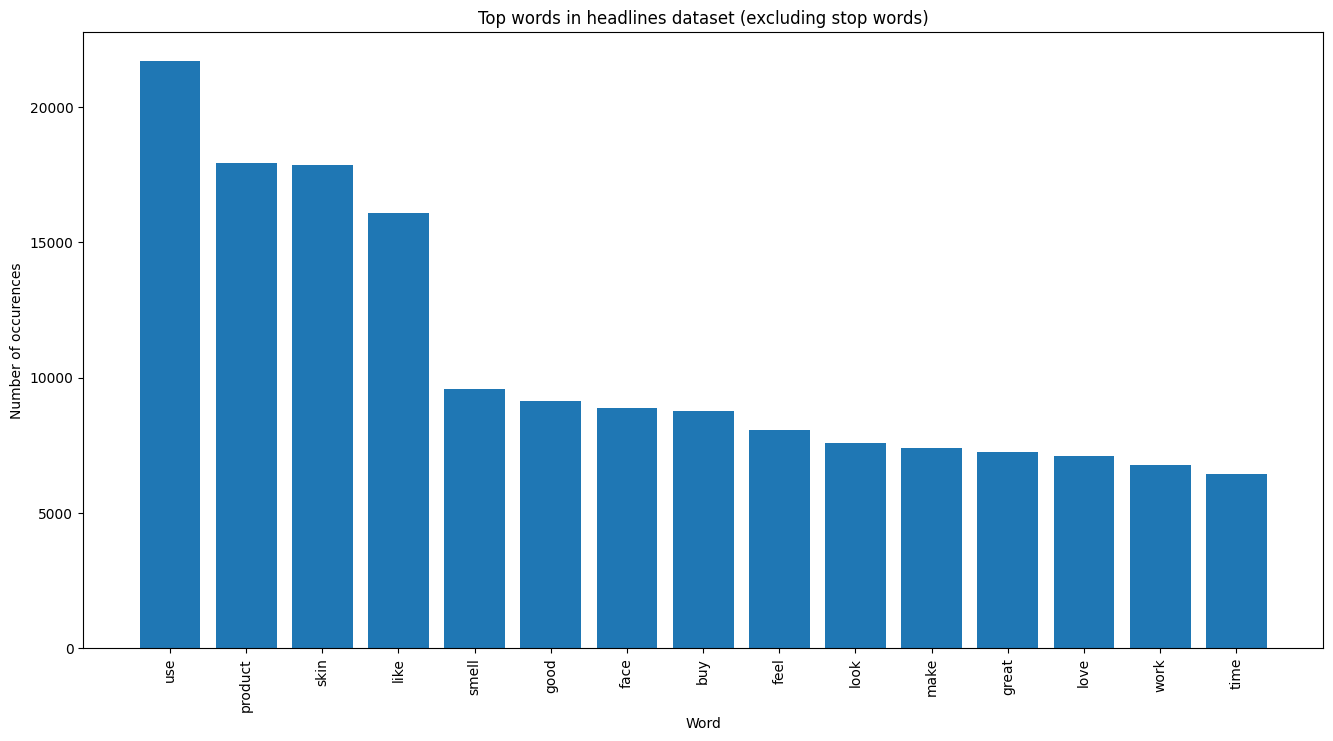

In [88]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=comment)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [89]:
tagged_headlines = [TextBlob(comment[i]).pos_tags for i in range(comment.shape[0])]

In [90]:
tagged_headlines_df = pd.DataFrame({'tags':tagged_headlines})

word_counts = [] 
pos_counts = {}

for headline in tagged_headlines_df[u'tags']:
    word_counts.append(len(headline))
    for tag in headline:
        if tag[1] in pos_counts:
            pos_counts[tag[1]] += 1
        else:
            pos_counts[tag[1]] = 1
            
print('Total number of words: ', np.sum(word_counts))
print('Mean number of words per headline: ', np.mean(word_counts))

Total number of words:  1230510
Mean number of words per headline:  27.006781818580865


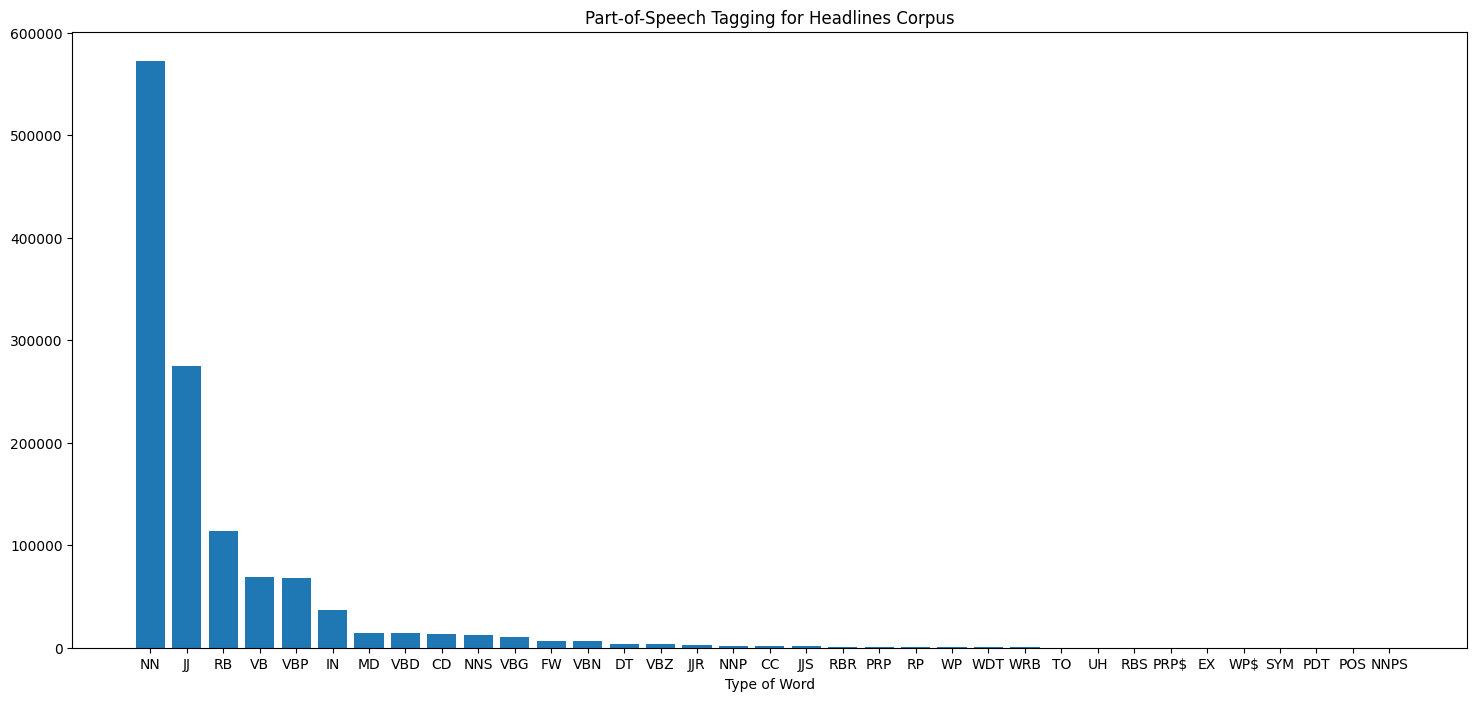

In [91]:
pos_sorted_types = sorted(pos_counts, key=pos_counts.__getitem__, reverse=True)
pos_sorted_counts = sorted(pos_counts.values(), reverse=True)

fig, ax = plt.subplots(figsize=(18,8))
ax.bar(range(len(pos_counts)), pos_sorted_counts);
ax.set_xticks(range(len(pos_counts)));
ax.set_xticklabels(pos_sorted_types);
ax.set_title('Part-of-Speech Tagging for Headlines Corpus');
ax.set_xlabel('Type of Word');

In [92]:
comment = data[(data.category == "Boys' Fashion") & (data.sub_category == "Clothing")].comment
comment

0       really want like problem order color option tw...
1       shirt look great picture wash seam start pull ...
2       bad item ever purchase son look cheap poor qua...
3       product definitely miss mark begin white shirt...
4       single stitch seam video first wash never warn...
                              ...                        
1472    gift yo daughter go pancake bacon egg sweater ...
1473    nice shirt true size logo come blank box look ...
1474                           grand son love fit perfect
1475    son love fit expect come time material awesome...
1476    little worried sleepware would scratchy rough ...
Name: comment, Length: 461, dtype: object

In [93]:
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
small_document_term_matrix = small_count_vectorizer.fit_transform(comment)

In [94]:
n_topics = 8

### Latent Semantic Analysis

In [95]:
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)

In [96]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [97]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [98]:
# Define helper functions
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [99]:
top_n_words_lsa = get_top_n_words(10, lsa_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  size fit son wear like order buy small color look
Topic 2:  size small medium defeny right gray grain grand grandchild granddaughter
Topic 3:  shirt sleeve look like wash cut hem edge sew make
Topic 4:  tag underwear tagless soft son pair say smell return sew
Topic 5:  fit great long perfect good di way waist trunk boy
Topic 6:  short like look son small package order picture use black
Topic 7:  mesh liner trunk swim time suit la leg buy rash
Topic 8:  son love trunk day waist little swim wish sock order


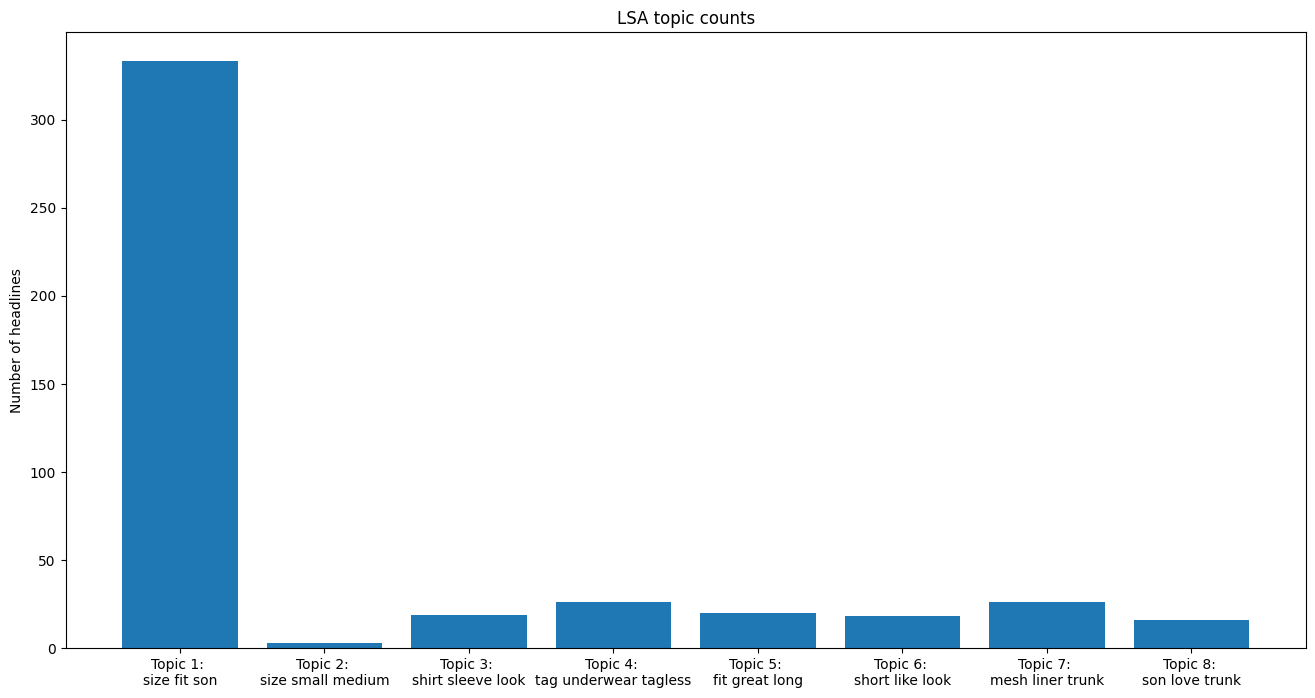

In [112]:
top_3_words = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i+1) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of headlines');
ax.set_title('LSA topic counts');
plt.show()

In [101]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 461 samples in 0.000s...
[t-SNE] Computed neighbors for 461 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 461 / 461
[t-SNE] Mean sigma: 0.424528
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.276558
[t-SNE] KL divergence after 1600 iterations: 0.644194


In [102]:
# Define helper functions
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [103]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [104]:
top_3_words_lsa = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics))
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(n_topics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
                  text=top_3_words_lsa[t], text_color=colormap[t])
    plot.add_layout(label)
    
show(plot)

### Latent Dirichilet Allocation

In [105]:
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)

In [106]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [107]:
top_n_words_lda = get_top_n_words(10, lda_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  la muy el que talla lo cm para se si
Topic 2:  size son wear small tag return great material little wash
Topic 3:  wash di dry underwear heavy wear fabric summer shrinkage sono
Topic 4:  pocket pajama zipper lack use garment deserve star split great
Topic 5:  shirt buy wash look color like little edge wear end
Topic 6:  smell say nice wash sensitive product floral cheap power especially
Topic 7:  size fit order short small like big son buy boy
Topic 8:  fit son look like buy good wear quality wash size


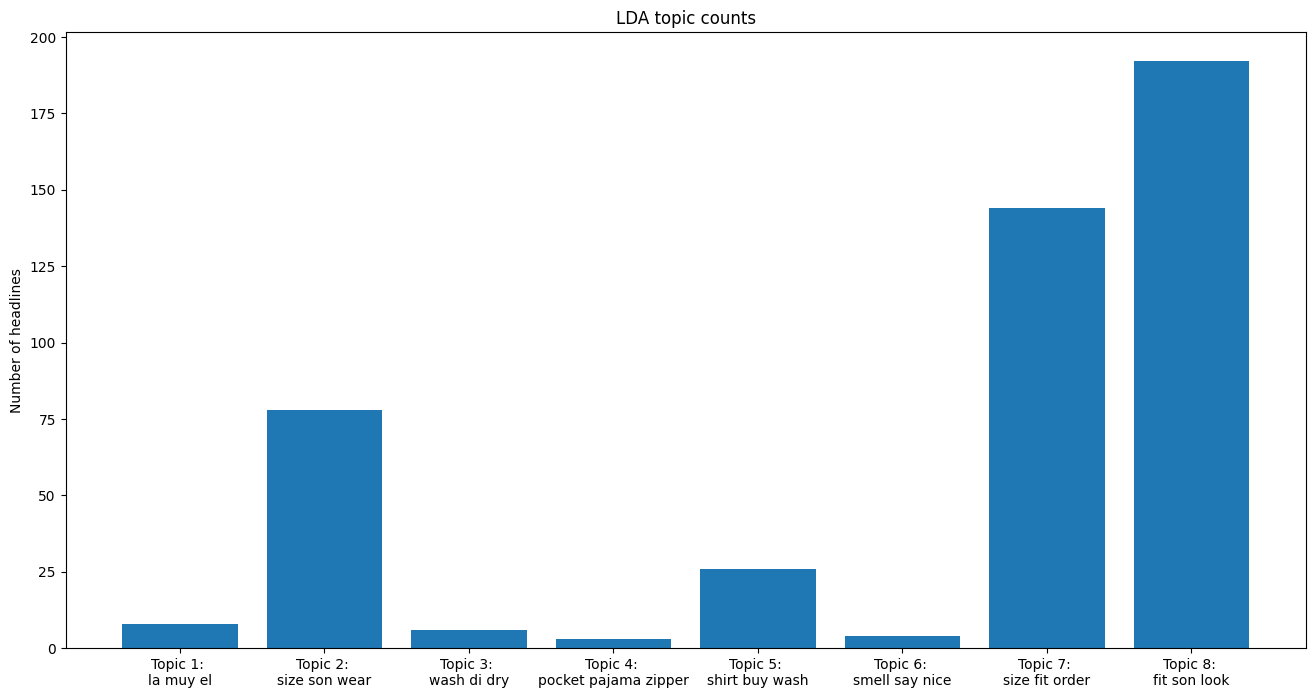

In [120]:
top_3_words = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i+1) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
ax.set_title('LDA topic counts');
ax.set_ylabel('Number of headlines');

In [109]:
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 461 samples in 0.000s...
[t-SNE] Computed neighbors for 461 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 461 / 461
[t-SNE] Mean sigma: 0.033682
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.393307
[t-SNE] KL divergence after 950 iterations: 0.154604


In [110]:
top_3_words_lda = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics))
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(n_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=top_3_words_lda[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

In [111]:
list_cmt_bad = data[(data.category == "Boys' Fashion") & (data.sub_category == "Clothing") & (data.label == 'bad')].comment
list_cmt_neutral = data[(data.category == "Boys' Fashion") & (data.sub_category == "Clothing") & (data.label == 'neutral')].comment
list_cmt_good = data[(data.category == "Boys' Fashion") & (data.sub_category == "Clothing") & (data.label == 'good')].comment


lst = [list_cmt_bad, list_cmt_neutral, list_cmt_good]
lb = ['không tốt', 'trung lập', 'tốt']

for idx, list_cmt in enumerate(lst): 
    print(f'Với các đánh giá {lb[idx]} trích xuất được những đặc trưng bao gồm:')
    # Tiền xử lý dữ liệu
    texts = [[word for word in review.lower().split()] for review in list_cmt]
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    # Xây dựng model LDA
    lda = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=3)

    # In ra các chủ đề và các từ khóa tương ứng
    for topic in lda.show_topics():
        print(topic)
    
    print()
    print()
    print()

Với các đánh giá không tốt trích xuất được những đặc trưng bao gồm:
(0, '0.011*"color" + 0.010*"size" + 0.009*"would" + 0.009*"small" + 0.009*"son" + 0.008*"look" + 0.007*"tag" + 0.007*"back" + 0.007*"short" + 0.007*"wear"')
(1, '0.018*"wear" + 0.016*"son" + 0.015*"size" + 0.014*"wash" + 0.012*"return" + 0.011*"fit" + 0.011*"shirt" + 0.011*"look" + 0.011*"small" + 0.010*"order"')
(2, '0.021*"size" + 0.013*"like" + 0.012*"order" + 0.012*"trunk" + 0.010*"return" + 0.009*"son" + 0.009*"get" + 0.009*"small" + 0.008*"short" + 0.007*"way"')



Với các đánh giá trung lập trích xuất được những đặc trưng bao gồm:
(0, '0.022*"son" + 0.018*"size" + 0.013*"tag" + 0.013*"fit" + 0.012*"buy" + 0.012*"small" + 0.011*"order" + 0.011*"little" + 0.009*"quality" + 0.009*"wear"')
(1, '0.027*"size" + 0.017*"like" + 0.015*"fit" + 0.015*"son" + 0.013*"look" + 0.011*"would" + 0.010*"s" + 0.010*"one" + 0.010*"buy" + 0.010*"short"')
(2, '0.016*"shirt" + 0.015*"small" + 0.013*"size" + 0.010*"order" + 0.010*"like"